## Trying to understand how input variance relates to the performance of our model

#### Part 1: does a lower amount of training images per label mean that images of that label will be mislabeled at test.
*Note: the Ground truth is only 90% true (based on Transformer predictions). so this study is an approximation, tells about the direction the conclusion might head. Neither part is conclusive anyway.

Number of entries per label:
label
1      35
2      35
3      33
4      35
5      19
       ..
196     6
197     5
198     5
199     5
200     5
Name: count, Length: 200, dtype: int64


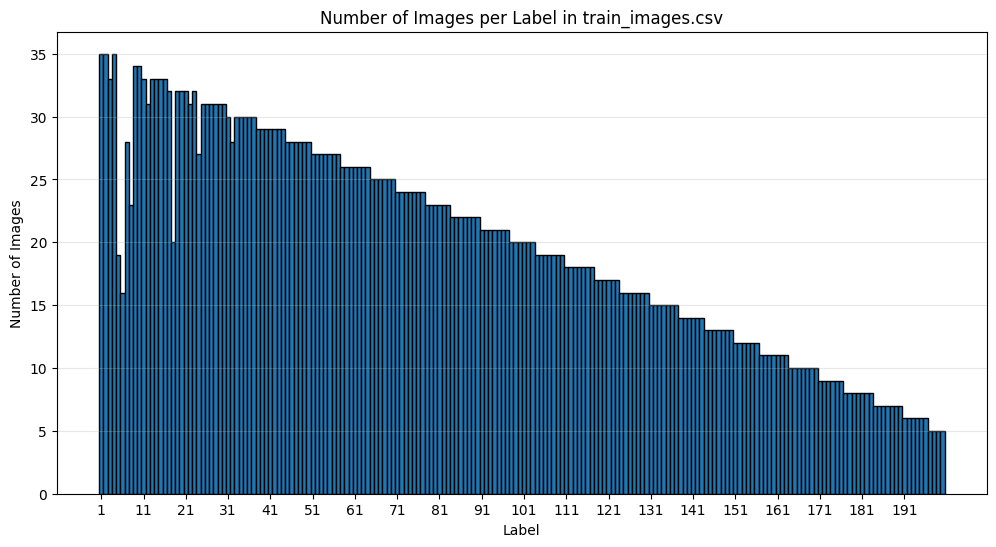

In [10]:
import pandas as pd

# Read the CSV
df = pd.read_csv('dataset/train_images.csv')

# Count entries per label
counts = df['label'].value_counts().sort_index()

# Print the counts
print("Number of entries per label:")
print(counts)

import matplotlib.pyplot as plt

# Assuming counts is already computed as above
plt.figure(figsize=(12, 6))
plt.bar(counts.index, counts.values, width=1.0, edgecolor='black')
plt.xlabel('Label')
plt.ylabel('Number of Images')
plt.title('Number of Images per Label in train_images.csv')
plt.xticks(range(1, 201, 10))  # Show every 10th label for readability
plt.grid(axis='y', alpha=0.3)
plt.show()

Number of entries per label:
label
1      35
2      35
3      33
4      35
5      19
       ..
196     6
197     5
198     5
199     5
200     5
Name: count, Length: 200, dtype: int64


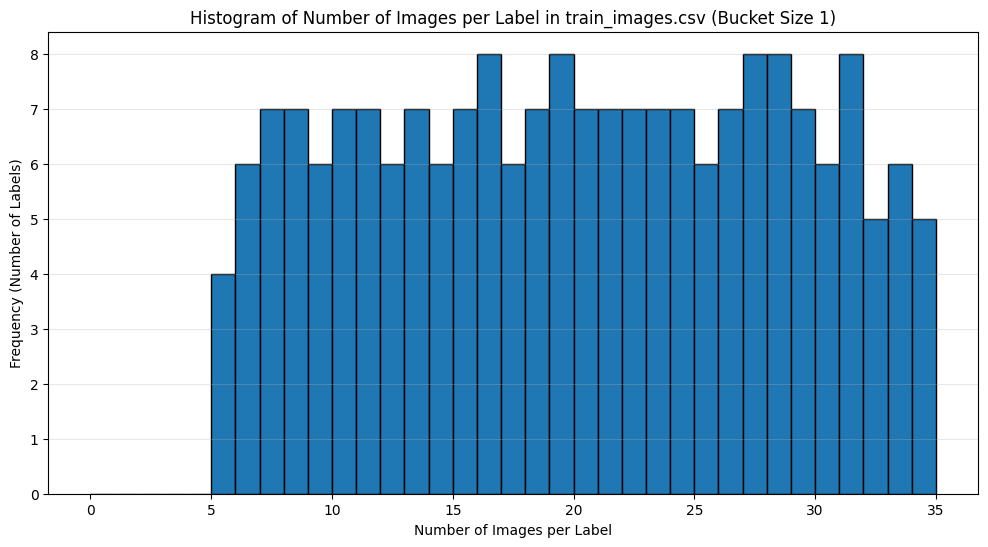

In [114]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the train data
train_df = pd.read_csv('dataset/train_images.csv')

# Load "ground truth"
inverto_gt_df = pd.read_csv('../Bird-recognition-cnn/results/test_images_prediction_INVERTO.csv')

# Load predictions
predict_df = pd.read_csv('results/predict_test.csv')



# Count entries per label
counts = train_df['label'].value_counts().sort_index()

# Print the counts
print("Number of entries per label:")
print(counts)

# Histogram of frequencies with bucket size 5
plt.figure(figsize=(12, 6))
max_count = int(counts.values.max())
plt.hist(counts.values, bins=range(0, max_count + 1, 1), edgecolor='black')
plt.xlabel('Number of Images per Label')
plt.ylabel('Frequency (Number of Labels)')
plt.title('Histogram of Number of Images per Label in train_images.csv (Bucket Size 1)')
plt.grid(axis='y', alpha=0.3)
plt.show()

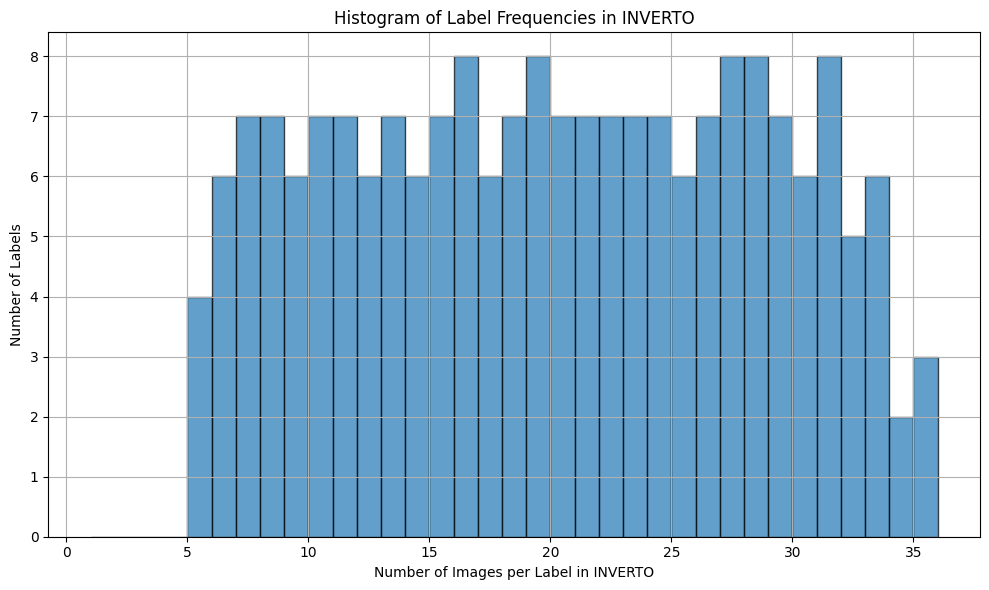

In [115]:
# Histogram of label frequencies (i.e., how many labels have X number of images in INVERTO)
plt.figure(figsize=(10, 6))
plt.hist(counts.values, bins=range(1, max(counts.values)+2), edgecolor='black', alpha=0.7)
plt.xlabel("Number of Images per Label in INVERTO")
plt.ylabel("Number of Labels")
plt.title("Histogram of Label Frequencies in INVERTO")
plt.grid(True)
plt.tight_layout()
plt.show()


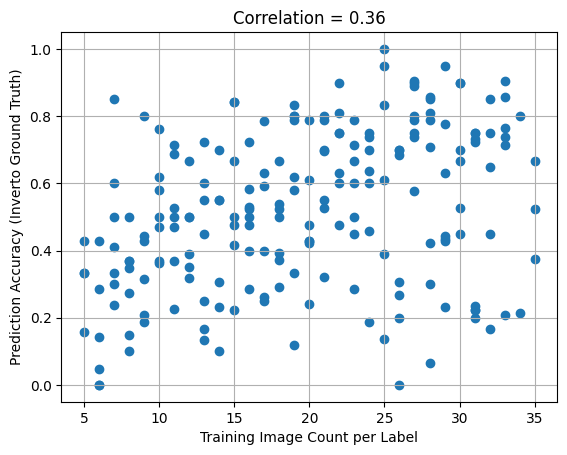

np.float64(0.35809232970222493)

In [116]:
# Step 1: Count how many training images each label has
train_label_counts = train_df['label'].value_counts().rename("train_count")

# Step 2: Merge predictions with inverto ground truth to compare
merged_df = predict_df.merge(inverto_gt_df, on='id', suffixes=('_pred', '_true'))

# Step 3: Compute correct predictions
merged_df['correct'] = merged_df['label_pred'] == merged_df['label_true']

# Step 4: Group by ground truth label to compute accuracy per label
label_accuracy = merged_df.groupby('label_true').agg(
    total_samples=('correct', 'count'),
    correct_predictions=('correct', 'sum')
)
label_accuracy['accuracy'] = label_accuracy['correct_predictions'] / label_accuracy['total_samples']

# Step 5: Combine with training counts
combined_stats = label_accuracy.join(train_label_counts, how='left')
combined_stats = combined_stats.fillna(0)  # Fill missing train labels with 0

import seaborn as sns
import matplotlib.pyplot as plt

# Step 6: Correlation analysis
correlation = combined_stats['train_count'].corr(combined_stats['accuracy'])

# Plotting the relationship
plt.scatter(combined_stats['train_count'], combined_stats['accuracy'])
plt.xlabel('Training Image Count per Label')
plt.ylabel('Prediction Accuracy (Inverto Ground Truth)')
plt.title(f'Correlation = {correlation:.2f}')
plt.grid(True)
plt.show()

combined_stats_sorted = combined_stats.sort_values(by='train_count', ascending=False)
correlation

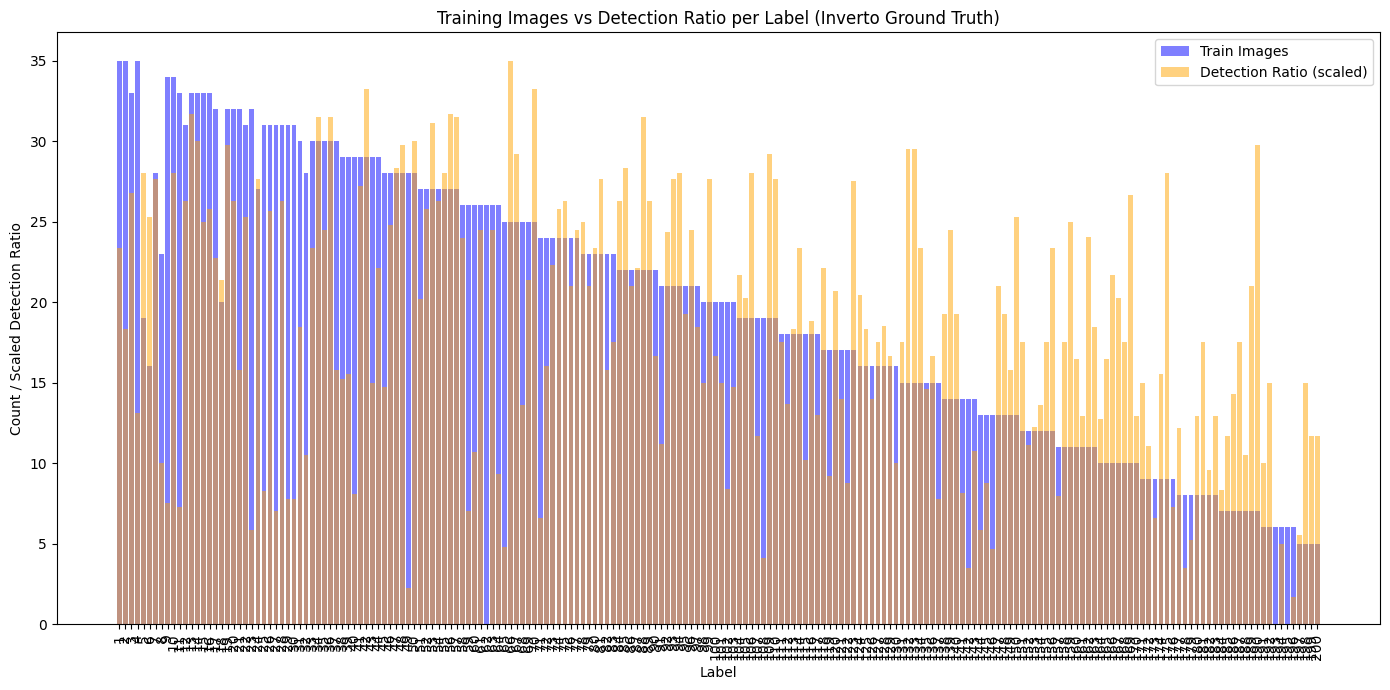

,train_count,inverto_count,correct_predictions,detection_ratio
1,35,21,14.0,0.666667
2,35,21,11.0,0.523810
3,33,17,13.0,0.764706
4,35,24,9.0,0.375000
5,19,20,16.0,0.800000
...,...,...,...,...
196,6,21,1.0,0.047619
197,5,19,3.0,0.157895
198,5,21,9.0,0.428571
199,5,18,6.0,0.333333


In [117]:
import pandas as pd

# Step 1: Count total occurrences of each label in inverto (ground truth)
inverto_label_counts = inverto_gt_df['label'].value_counts().rename("inverto_count")

# Step 2: Identify where predictions match inverto
correct_preds = predict_df.merge(inverto_gt_df, on='id')
correct_preds = correct_preds[correct_preds['label_x'] == correct_preds['label_y']]
correct_label_counts = correct_preds['label_x'].value_counts().rename("correct_predictions")

# Step 3: Create DataFrame of ratios
label_detection_ratios = pd.DataFrame({
    'correct_predictions': correct_label_counts,
    'inverto_count': inverto_label_counts
}).fillna(0)

label_detection_ratios['detection_ratio'] = label_detection_ratios['correct_predictions'] / label_detection_ratios['inverto_count']

# Step 4: Merge with training image counts
final_ratios = label_detection_ratios.join(train_label_counts.rename("train_count"), how='left').fillna(0)

# Plotting the updated bar plot with detection ratios (range 0-1)
plt.figure(figsize=(14, 7))
sorted_final = final_ratios.sort_index()
x = sorted_final.index.astype(str)

# Blue bars: number of training images
plt.bar(x, sorted_final['train_count'], label='Train Images', alpha=0.5, color='blue')

# Orange bars: detection ratios scaled to same y-axis
scaled_ratios = sorted_final['detection_ratio'] * sorted_final['train_count'].max()
plt.bar(x, scaled_ratios, label='Detection Ratio (scaled)', alpha=0.5, color='orange')

plt.xlabel("Label")
plt.ylabel("Count / Scaled Detection Ratio")
plt.title("Training Images vs Detection Ratio per Label (Inverto Ground Truth)")
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

#import ace_tools as tools; tools.display_dataframe_to_user(name="Final Label Detection Ratios", dataframe=final_ratios)

final_ratios[['train_count', 'inverto_count', 'correct_predictions', 'detection_ratio']]


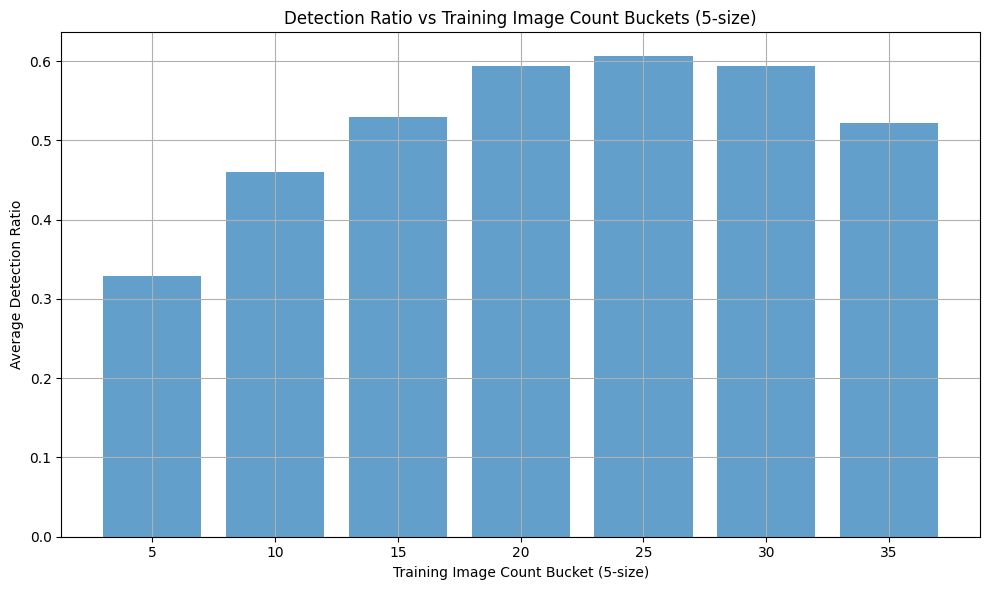

,train_bucket,avg_detection_ratio,num_labels
0,5,0.329348,30
1,10,0.460422,33
2,15,0.529464,36
3,20,0.593397,35
4,25,0.606163,36
5,30,0.594270,27
6,35,0.521825,3


In [194]:
# Group labels into buckets based on their training image count, using a bucket size of 5
bucket_size = 5
final_ratios['train_bucket'] = (final_ratios['train_count'] // bucket_size) * bucket_size

# Group by these buckets and calculate average detection ratio and total labels in each
bucket_stats = final_ratios.groupby('train_bucket').agg(
    avg_detection_ratio=('detection_ratio', 'mean'),
    num_labels=('detection_ratio', 'count')
).reset_index()

# Plot average detection ratio by training image count bucket
plt.figure(figsize=(10, 6))
plt.bar(bucket_stats['train_bucket'].astype(str), bucket_stats['avg_detection_ratio'], alpha=0.7)
plt.xlabel("Training Image Count Bucket (%s-size)"%bucket_size)
plt.ylabel("Average Detection Ratio")
plt.title("Detection Ratio vs Training Image Count Buckets (%s-size)"%bucket_size)
plt.grid(True)
plt.tight_layout()
plt.show()

#import ace_tools as tools; tools.display_dataframe_to_user(name="Bucketed Detection Ratios", dataframe=bucket_stats)

bucket_stats


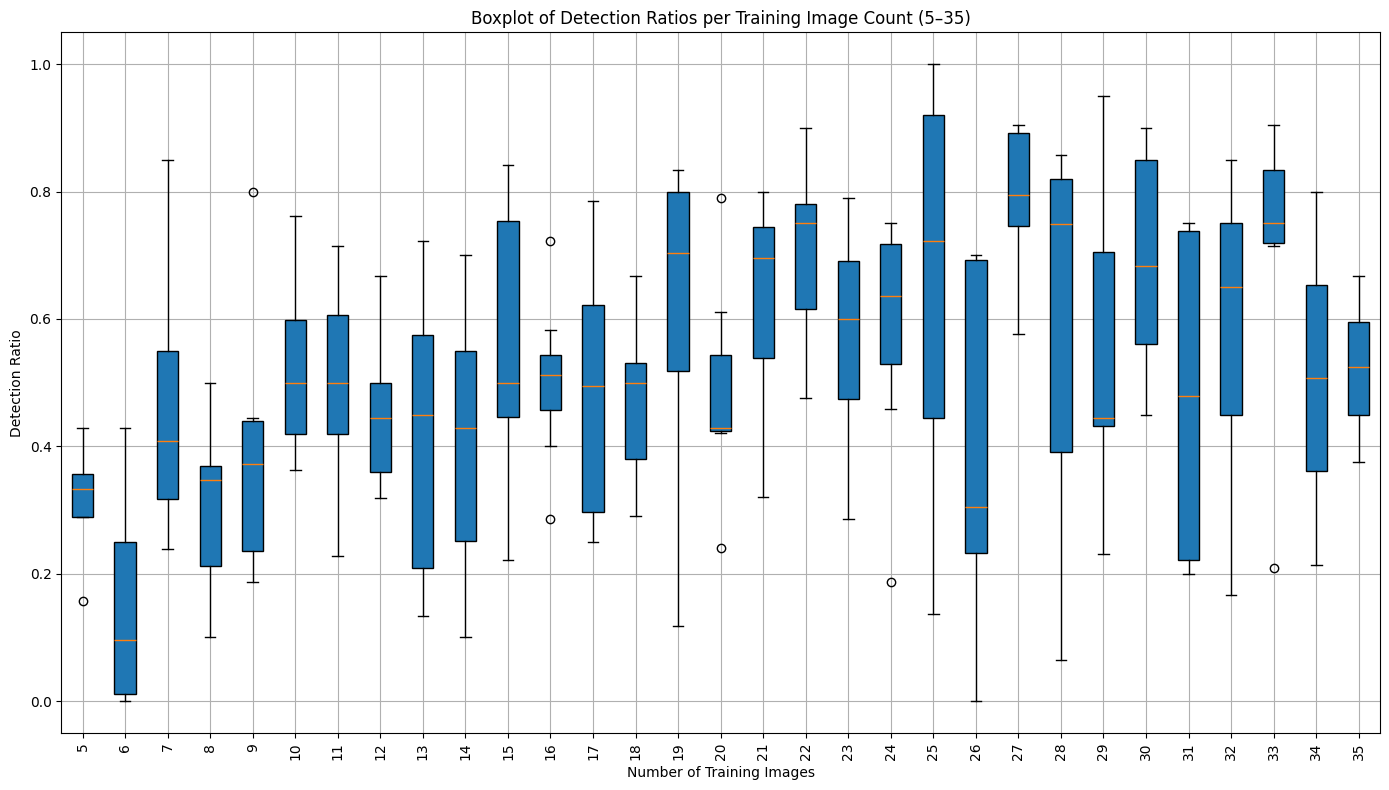

In [195]:
# Filter data for train counts in range 5 to 35
filtered_ratios = final_ratios[(final_ratios['train_count'] >= 5) & (final_ratios['train_count'] <= 35)]

# Create boxplots of detection ratios for each train_count value
plt.figure(figsize=(14, 8))
filtered_ratios_sorted = filtered_ratios.sort_values(by='train_count')
ax = plt.boxplot(
    [filtered_ratios_sorted[filtered_ratios_sorted['train_count'] == count]['detection_ratio']
     for count in range(5, 36)],
    positions=range(5, 36),
    patch_artist=True
)

plt.xlabel("Number of Training Images")
plt.ylabel("Detection Ratio")
plt.title("Boxplot of Detection Ratios per Training Image Count (5–35)")
plt.grid(True)
plt.xticks(range(5, 36), rotation=90)
plt.tight_layout()
plt.show()


## Investigate distribution in Test (90%) certainty

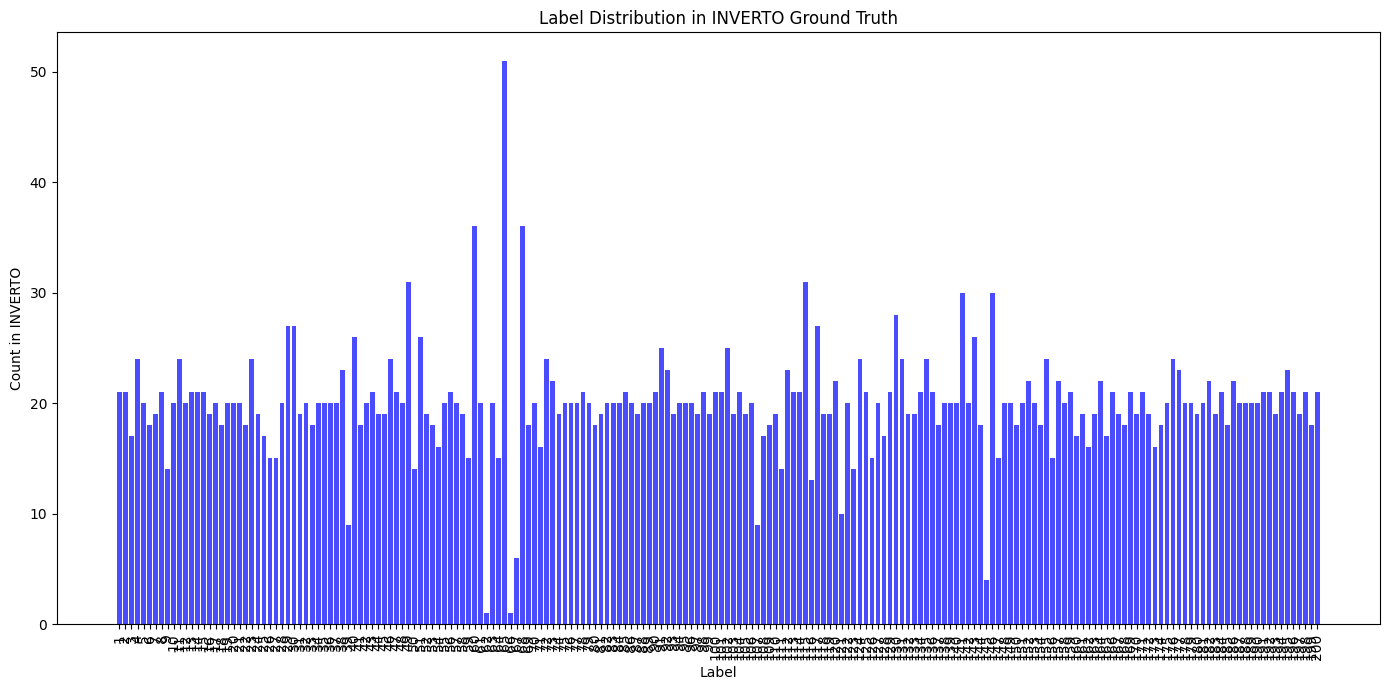

In [196]:
import matplotlib.pyplot as plt

# Count labels in INVERTO
inverto_label_counts = inverto_gt_df['label'].value_counts().sort_index()

# Bar chart
plt.figure(figsize=(14, 7))
plt.bar(inverto_label_counts.index.astype(str), inverto_label_counts.values, color='blue', alpha=0.7)
plt.xlabel("Label")
plt.ylabel("Count in INVERTO")
plt.title("Label Distribution in INVERTO Ground Truth")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


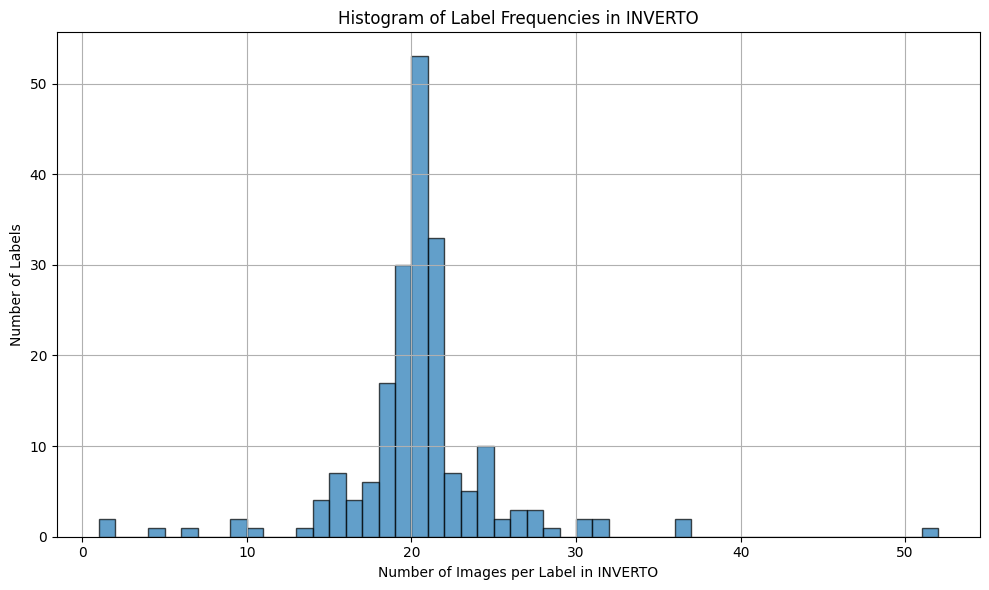

In [197]:
# Histogram of label frequencies (i.e., how many labels have X number of images in INVERTO)
plt.figure(figsize=(10, 6))
plt.hist(inverto_label_counts.values, bins=range(1, max(inverto_label_counts.values)+2), edgecolor='black', alpha=0.7)
plt.xlabel("Number of Images per Label in INVERTO")
plt.ylabel("Number of Labels")
plt.title("Histogram of Label Frequencies in INVERTO")
plt.grid(True)
plt.tight_layout()
plt.show()


## Part 2: Create families of species to see how much of our error falls within one Genus_Category

#### *Note: some genus_categories have birds which are similar: Sparrows, others differ significantly in at least one direction: color, or tail. To improve, we need a more granular group to say birds are very similar. 

In [198]:


# simple 2D array -> DataFrame (rows x cols)

arr = np.load(r'dataset/class_names.npy', allow_pickle=True)

# diagnostics
print('raw type:', type(arr), 'shape:', getattr(arr, 'shape', None), 'ndim:', getattr(arr, 'ndim', None), 'dtype:', getattr(arr, 'dtype', None))

# unwrap 0-d pickled object
if np.ndim(arr) == 0:
    obj = arr.tolist()
    print('unwrapped 0-d ->', type(obj))

    # handle dict stored inside the .npy
    if isinstance(obj, dict):
        print('dict keys sample:', list(obj.keys())[:10])

        # extract number and species from keys like "001.Black_footed_Albatross"
        entries = []
        for k in obj.keys():
            ks = str(k)
            if '.' in ks:
                num_str, species_raw = ks.split('.', 1)
            else:
                # fallback: try to separate digits prefix
                import re
                m = re.match(r'(\d+)[-_\.]?(.*)', ks)
                if m:
                    num_str, species_raw = m.group(1), m.group(2)
                else:
                    num_str, species_raw = '', ks
            try:
                num = int(num_str)
            except Exception:
                num = num_str  # keep as string if not integer
            #species = species_raw.replace('_', ' ').strip()
            entries.append((num, species_raw))

        # sort by numeric id when possible
        try:
            entries = sorted(entries, key=lambda x: int(x[0]))
        except Exception:
            entries = sorted(entries, key=lambda x: str(x[0]))

        # build DataFrame with first column = label, second = species name
        df_cn = pd.DataFrame(entries, columns=['label', 'class_name'])
    else:
        # not a dict: make list-like
        arr = np.asarray(obj)
        if arr.ndim == 0:
            arr = np.asarray([arr])
        if arr.ndim == 1:
            df_cn = pd.DataFrame(arr, columns=['class_name'])
        else:
            df_cn = pd.DataFrame(arr)
else:
    # arr wasn't 0-d: coerce and build dataframe as before
    arr = np.asarray(arr)
    if arr.ndim == 1:
        df_cn = pd.DataFrame(arr, columns=['class_name'])
    else:
        df_cn = pd.DataFrame(arr)

print('df_cn shape:', df_cn.shape)
df_cn[0:20]


raw type: <class 'numpy.ndarray'> shape: () ndim: 0 dtype: object
unwrapped 0-d -> <class 'dict'>
dict keys sample: [np.str_('001.Black_footed_Albatross'), np.str_('002.Laysan_Albatross'), np.str_('003.Sooty_Albatross'), np.str_('004.Groove_billed_Ani'), np.str_('005.Crested_Auklet'), np.str_('006.Least_Auklet'), np.str_('007.Parakeet_Auklet'), np.str_('008.Rhinoceros_Auklet'), np.str_('009.Brewer_Blackbird'), np.str_('010.Red_winged_Blackbird')]
df_cn shape: (200, 2)


,label,class_name
0,1,Black_footed_Albatross
1,2,Laysan_Albatross
2,3,Sooty_Albatross
3,4,Groove_billed_Ani
4,5,Crested_Auklet
5,6,Least_Auklet
6,7,Parakeet_Auklet
7,8,Rhinoceros_Auklet
8,9,Brewer_Blackbird
9,10,Red_winged_Blackbird


In [209]:
df_cn['genus_category'] = df_cn['class_name'].str.split('_').str[-1]
df_cn[20:50]


,label,class_name,genus_category
20,21,Eastern_Towhee,Towhee
21,22,Chuck_will_Widow,Widow
22,23,Brandt_Cormorant,Cormorant
23,24,Red_faced_Cormorant,Cormorant
24,25,Pelagic_Cormorant,Cormorant
25,26,Bronzed_Cowbird,Cowbird
26,27,Shiny_Cowbird,Cowbird
27,28,Brown_Creeper,Creeper
28,29,American_Crow,Crow
29,30,Fish_Crow,Crow


In [219]:
""" 
# Group by genus_category and collect lists of class_name
grouped = df_cn.groupby('genus_category')['label'].apply(list)

# Print the list for each genus_category
for genus, labels in grouped.items():
    print(f"Genus Category: {genus}")
    print("Labels:")
    for label in labels:
        print(f"  - {label}")
    print() """

' \n# Group by genus_category and collect lists of class_name\ngrouped = df_cn.groupby(\'genus_category\')[\'label\'].apply(list)\n\n# Print the list for each genus_category\nfor genus, labels in grouped.items():\n    print(f"Genus Category: {genus}")\n    print("Labels:")\n    for label in labels:\n        print(f"  - {label}")\n    print() '

In [220]:

# Create a dictionary with genus_category as key and list of labels as value
genus_groups = {}
for genus, labels in grouped.items():
    genus_groups[genus] = labels

# Print the dictionary
print(genus_groups)

{'Albatross': [1, 2, 3], 'Ani': [4], 'Auklet': [5, 6, 7, 8], 'Blackbird': [9, 10, 11, 12], 'Bobolink': [13], 'Bunting': [14, 15, 16], 'Cardinal': [17], 'Catbird': [18, 19], 'Chat': [20], 'Cormorant': [23, 24, 25], 'Cowbird': [26, 27], 'Creeper': [28], 'Crow': [29, 30], 'Cuckoo': [31, 32, 33], 'Finch': [34, 35], 'Flicker': [36], 'Flycatcher': [37, 38, 39, 40, 41, 42, 43], 'Frigatebird': [44], 'Fulmar': [45], 'Gadwall': [46], 'Geococcyx': [110], 'Goldfinch': [47, 48], 'Grackle': [49], 'Grebe': [50, 51, 52, 53], 'Grosbeak': [54, 55, 56, 57], 'Guillemot': [58], 'Gull': [59, 60, 61, 62, 63, 64, 65, 66], 'Hummingbird': [67, 68, 69], 'Jaeger': [71, 72], 'Jay': [73, 74, 75], 'Junco': [76], 'Kingbird': [77, 78], 'Kingfisher': [79, 80, 81, 82, 83], 'Kittiwake': [84], 'Lark': [85], 'Loon': [86], 'Mallard': [87], 'Meadowlark': [88], 'Merganser': [89, 90], 'Mockingbird': [91], 'Nighthawk': [92], 'Nutcracker': [93], 'Nuthatch': [94], 'Oriole': [95, 96, 97, 98], 'Ovenbird': [99], 'Pelican': [100, 101

In [229]:
""" # Step 2: Identify where predictions dont match inverto
correct_preds = predict_df.merge(inverto_gt_df, on='id')
#correct_preds = correct_preds[correct_preds['label_x'] == correct_preds['label_y']]
#correct_label_counts = correct_preds['label_x'].value_counts().rename("correct_predictions")




# Find mismatches where predicted != INVERTO
merge_pred = predict_df.merge(inverto_gt_df, on='id', suffixes=('_pred', '_inverto'))

mismatches = merge_pred[merge_pred['label_pred'] != merge_pred['label_inverto']]


# Print the mismatches: id, predicted, INVERTO
print("Mismatches:")
print(mismatches[['id', 'label_pred', 'label_inverto']])
 """

' # Step 2: Identify where predictions dont match inverto\ncorrect_preds = predict_df.merge(inverto_gt_df, on=\'id\')\n#correct_preds = correct_preds[correct_preds[\'label_x\'] == correct_preds[\'label_y\']]\n#correct_label_counts = correct_preds[\'label_x\'].value_counts().rename("correct_predictions")\n\n\n\n\n# Find mismatches where predicted != INVERTO\nmerge_pred = predict_df.merge(inverto_gt_df, on=\'id\', suffixes=(\'_pred\', \'_inverto\'))\n\nmismatches = merge_pred[merge_pred[\'label_pred\'] != merge_pred[\'label_inverto\']]\n\n\n# Print the mismatches: id, predicted, INVERTO\nprint("Mismatches:")\nprint(mismatches[[\'id\', \'label_pred\', \'label_inverto\']])\n '

In [230]:

# Count how many mismatches have the same genus_category
same_genus_count = 0
for _, row in mismatches.iterrows():
    label_pred = row['label_pred']
    label_inverto = row['label_inverto']
    genus_pred = df_cn[df_cn['label'] == label_pred]['genus_category'].values[0]
    genus_inverto = df_cn[df_cn['label'] == label_inverto]['genus_category'].values[0]
    if genus_pred == genus_inverto:
        same_genus_count += 1

print(f"Number of mismatches where predicted and INVERTO labels are in the same genus category: {same_genus_count}")

Number of mismatches where predicted and INVERTO labels are in the same genus category: 630


In [231]:
same_genus_count

630

In [232]:
len(mismatches)

1959

In [233]:
matches = merge_pred[merge_pred['label_pred'] == merge_pred['label_inverto']]
len(matches)


2041

In [234]:

# Print the statement
total_mismatches = len(mismatches)
percentage = (same_genus_count / total_mismatches) * 100 if total_mismatches > 0 else 0
print(f"Of the incorrectly labeled {total_mismatches} images, {percentage:.2f}% are of the same genus_category")

Of the incorrectly labeled 1959 images, 32.16% are of the same genus_category


In [235]:

# Calculate new accuracy
total_images = len(merged_df)
new_correct = len(matches) + same_genus_count
new_accuracy = new_correct / total_images

print(f"If we included members of the same genus_category, the model accuracy becomes {new_accuracy:.4f}")

If we included members of the same genus_category, the model accuracy becomes 0.6677
